In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense,Conv1D,MaxPooling1D,UpSampling1D,Flatten,add
from tensorflow.keras.callbacks import ModelCheckpoint

from AD_tools import * # specifically need training()

In [2]:
plt.rcParams.update({
    'figure.figsize': (6,5),
    'font.size': 16,
    })

In [3]:
name = "1-1"

In [4]:
# J_x/J_||   extrap    lower   upper
# data from https://arxiv.org/abs/1805.11017
theory_1st = np.loadtxt("data/theory_1st.txt")
theory_2nd = np.loadtxt("data/theory_2nd.txt")

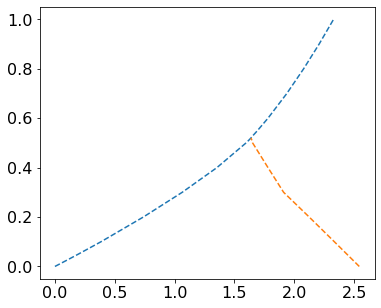

In [5]:
plt.plot(theory_1st[:,1],theory_1st[:,0],"--")
plt.plot(theory_2nd[:,1],theory_2nd[:,0],"--")

In [6]:
data = np.loadtxt("data/dataD6weights2Drand.txt")
data.shape

(4131, 27)

In [7]:
#sorter = np.argsort(data[:,1])
#data = data[sorter]

In [8]:
xx, yy = data[:,0], data[:,1]

In [9]:
x_data = data[:,3:]

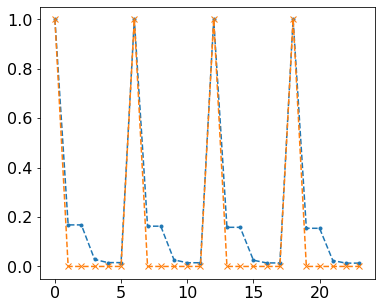

In [10]:
plt.plot(x_data[0],".--")
plt.plot(x_data[-1],"x--")

In [11]:
x_test = x_data.reshape((x_data.shape[0],4,6)).transpose((0,2,1))
x_test.shape

(4131, 6, 4)

In [12]:
ux = np.unique(xx)
uy = np.unique(yy)
X,Y = np.meshgrid(ux,uy)

In [13]:
rate=0.2 # Dropout percentage
bottleneck = 50 # latent space dimension, does not make great differences
fully = True

In [14]:
def cnnx(loss,optimizer,activation0,activation,x_shape,dim1=(16,(3,)),dim2=(16,(3,)), fully=False):
    """ 
    Pretty Standard Convolutional Autoencoder with a fully-connected latent space
    activation0: Activations "inside" the CAE
    activation: Last activation (important depending on the range of the pixel values)
    """
    in_dim = x_shape
    input_img = Input(shape=in_dim)
   
    #x1 = Conv1D(*dim1, activation=activation0, padding='same')(input_img)
    #x2 = MaxPooling1D((2,), padding='same')(x1)
    #x2 = Conv1D(*dim2, activation=activation0, padding='same')(x2)
    #x3 = MaxPooling1D((2,), padding='same')(x2)
    #encoded = Conv1D(*dim2, activation=activation0, padding='same')(x2)
    
    encoded = Flatten()(input_img)
    encoded = Dense(units=100,activation=activation0)(encoded)
    encoded = tf.keras.layers.Dropout(rate)(encoded)
    encoded = Dense(units=25,activation=activation0)(encoded)
    
    y = Dense(units=100,activation=activation0)(encoded)
    y = tf.keras.layers.Dropout(rate)(y)

    #y=UpSampling1D(2)(encoded)
    #y=Conv1D(*dim1, activation=activation0, padding='same')(y)
    #y=UpSampling1D(2)(y)
    decoded = Dense(np.prod(in_dim), activation=activation)(y)
    decoded = tf.keras.layers.Reshape(in_dim)(decoded)
    

    cnn = Model(input_img, decoded)
    cnn.compile(loss=loss,optimizer=optimizer)
    return cnn

In [15]:
# Show Network architecture
cnn = cnnx("mse","adam","linear","relu",x_shape=(6,4))
cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 4)]            0         
_________________________________________________________________
flatten (Flatten)            (None, 24)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               2500      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0     

In [16]:
def norm2(y_true,y_pred):
    """ just the standard l2 norm, needed for evaluation """
    return np.sqrt(np.sum(np.abs(y_true - y_pred)**2))

def eval_loss(x_batch,y_batch,norm=norm2):
    a = []
    for i in range(x_batch.shape[0]):
        a.append(norm(x_batch[i],y_batch[i]))
    return np.array(a)

def training_run(x_train,choose_cnn, name = "", provide_cnn = False,
             load_prev=False, num_epochs = 10,  verbose_val=1, batch_size = 128, shuffle=True, early=False,
             loss="mse", activation0 = 'relu', activation = 'linear', optimizer = "adam",
             dim1=(16,(3,3)),dim2=(16,(3,3)),ssc1=False,ssc2=False):
    """
    provide_cnn is to continue the training of a cnn
    load_prev is to load a previously trained network under the same paramters
    x_train provide training data
    """
        
    name_string = name
    CNN_filepath= 'CNN_data/Anomaly-Detection_' + name_string + 'weights.hdf5'

    cnn = choose_cnn(loss,optimizer,activation0,activation,x_train.shape[1:],dim1,dim2) #ssc1, ssc2
    if load_prev:
        cnn.load_weights(CNN_filepath)
    else:
        if provide_cnn:
            cnn = provide_cnn
        # checkpoint
        checkpoint = ModelCheckpoint(CNN_filepath, monitor='val_loss', verbose=0, save_best_only=False, mode='max')
        callbacks_list = [checkpoint]
        if early:
            early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None)#, restore_best_weights=True)
            callbacks_list.append(early_stop)

        history=cnn.fit(x_train, x_train, epochs=num_epochs, batch_size=batch_size,validation_data=(x_train,x_train),callbacks=callbacks_list,verbose=verbose_val,shuffle=shuffle)
        np.savez('CNN_data/Anomaly-Detection_history_cnn_' + name_string + '.npz',loss=history.history['loss'],val_loss=history.history['val_loss'])#,acc=history.history['acc'],val_acc=history.history['val_acc'])

    # training history
    plotname = 'plots/Anomaly-Detection_training-history' +  name_string
    hist = np.load('CNN_data/Anomaly-Detection_history_cnn_' + name_string + '.npz',allow_pickle="True")
    loss = hist["loss"]
    val_loss = hist["val_loss"]
    plt.plot(loss, linewidth=2, label='Train')
    plt.plot(val_loss, linewidth=2, label='Val')
    plt.legend(loc='upper right')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.yscale("log")
    #plt.ylim(ymin=0.70,ymax=1)
    plt.savefig(plotname + 'training.png', format="png")
    plt.show()
    return cnn

In [17]:
def create_out(cnn1):
    """
    Creates (dim_freq, dim_phase) matrix of the output loss and the standard deviation
    """
    images_out = cnn1.predict(x_test)

    res = eval_loss(x_test,images_out,norm=norm2)/eval_loss(x_test,0*x_test,norm=norm2)

    out = np.zeros((len(uphase),len(ufreq)))
    dout = np.zeros((len(uphase),len(ufreq)))

    for i,ph in enumerate(uphase):
        for j,fr in enumerate(ufreq):
            mask = np.intersect1d(np.where(freq == fr),np.where(phase == ph))
            out[i,j] = np.mean(res[mask])
            dout[i,j] = np.std(res[mask])
    return out, dout, res

In [18]:
def train_mask(x0,x1,y0,y1):
    pick_x = np.where((xx >= x0) & (xx <= x1))
    pick_y = np.where((yy >= y0) & (yy <= y1))
    return np.intersect1d(pick_x,pick_y)

# Data as is
i.e. no renormalization

In [19]:
# this is here the results, i.e. the loss values and its error are going to be saved
# res is the full-stack data list while out is averaged and aranged
cnns, outs, douts, res = [None] * 3,[None] * 3, [None] * 3, [None] * 3 

In [20]:
train_xss = [[(0,1)],[(3,4)],[(1,2)]]
train_yss = [[(0.8,1)],[(0.8,1)],[(0,0.1)]]

In [21]:
import time

In [22]:
num_epochs = [200,200,600]

[(231, 6, 4)]
(231, 6, 4)
Epoch 1/200
2/2 [==============================] - 1s 342ms/step - loss: 0.1574 - val_loss: 0.1411
Epoch 2/200
2/2 [==============================] - 0s 53ms/step - loss: 0.1419 - val_loss: 0.1244
Epoch 3/200
2/2 [==============================] - 0s 60ms/step - loss: 0.1271 - val_loss: 0.1082
Epoch 4/200
2/2 [==============================] - 0s 41ms/step - loss: 0.1100 - val_loss: 0.0916
Epoch 5/200
2/2 [==============================] - 0s 49ms/step - loss: 0.0947 - val_loss: 0.0747
Epoch 6/200
2/2 [==============================] - 0s 54ms/step - loss: 0.0788 - val_loss: 0.0584
Epoch 7/200
2/2 [==============================] - 0s 60ms/step - loss: 0.0635 - val_loss: 0.0428
Epoch 8/200
2/2 [==============================] - 0s 68ms/step - loss: 0.0524 - val_loss: 0.0289
Epoch 9/200
2/2 [==============================] - 0s 52ms/step - loss: 0.0413 - val_loss: 0.0179
Epoch 10/200
2/2 [==============================] - 0s 58ms/step - loss: 0.0328 - val_loss:

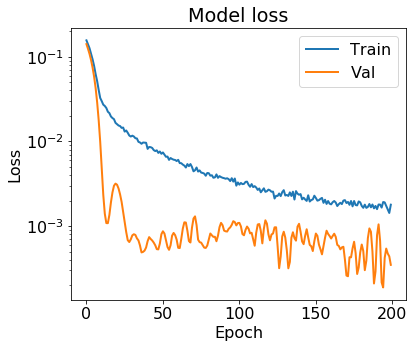

dt =  20.396612405776978


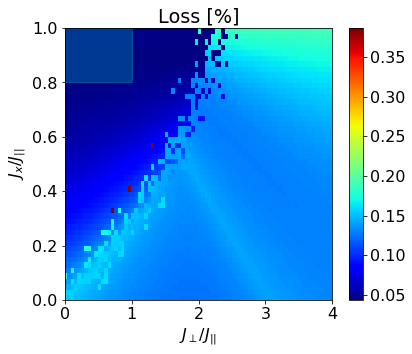

[(231, 6, 4)]
(231, 6, 4)
Epoch 1/200
2/2 [==============================] - 0s 145ms/step - loss: 0.1792 - val_loss: 0.1578
Epoch 2/200
2/2 [==============================] - 0s 46ms/step - loss: 0.1596 - val_loss: 0.1433
Epoch 3/200
2/2 [==============================] - 0s 46ms/step - loss: 0.1442 - val_loss: 0.1294
Epoch 4/200
2/2 [==============================] - 0s 44ms/step - loss: 0.1319 - val_loss: 0.1177
Epoch 5/200
2/2 [==============================] - 0s 45ms/step - loss: 0.1187 - val_loss: 0.1058
Epoch 6/200
2/2 [==============================] - 0s 43ms/step - loss: 0.1065 - val_loss: 0.0933
Epoch 7/200
2/2 [==============================] - 0s 40ms/step - loss: 0.0949 - val_loss: 0.0796
Epoch 8/200
2/2 [==============================] - 0s 44ms/step - loss: 0.0827 - val_loss: 0.0656
Epoch 9/200
2/2 [==============================] - 0s 46ms/step - loss: 0.0713 - val_loss: 0.0517
Epoch 10/200
2/2 [==============================] - 0s 131ms/step - loss: 0.0589 - val_loss

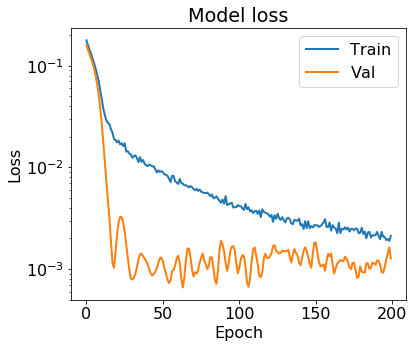

dt =  16.97059726715088


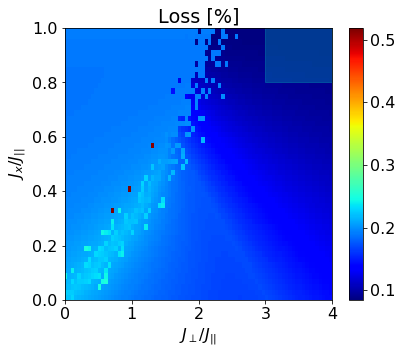

[(126, 6, 4)]
(126, 6, 4)
Epoch 1/600
1/1 [==============================] - 1s 573ms/step - loss: 0.1641 - val_loss: 0.1528
Epoch 2/600
1/1 [==============================] - 0s 43ms/step - loss: 0.1559 - val_loss: 0.1462
Epoch 3/600
1/1 [==============================] - 0s 43ms/step - loss: 0.1476 - val_loss: 0.1395
Epoch 4/600
1/1 [==============================] - 0s 43ms/step - loss: 0.1401 - val_loss: 0.1324
Epoch 5/600
1/1 [==============================] - 0s 43ms/step - loss: 0.1349 - val_loss: 0.1254
Epoch 6/600
1/1 [==============================] - 0s 41ms/step - loss: 0.1276 - val_loss: 0.1179
Epoch 7/600
1/1 [==============================] - 0s 46ms/step - loss: 0.1201 - val_loss: 0.1096
Epoch 8/600
1/1 [==============================] - 0s 45ms/step - loss: 0.1130 - val_loss: 0.1011
Epoch 9/600
1/1 [==============================] - 0s 44ms/step - loss: 0.1069 - val_loss: 0.0927
Epoch 10/600
1/1 [==============================] - 0s 43ms/step - loss: 0.0971 - val_loss:

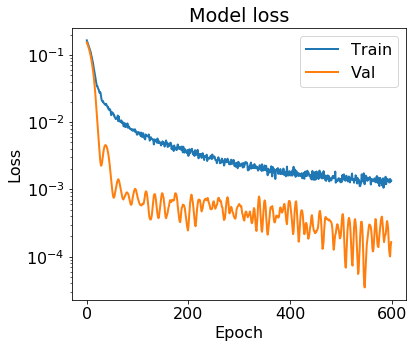

dt =  45.9531683921814


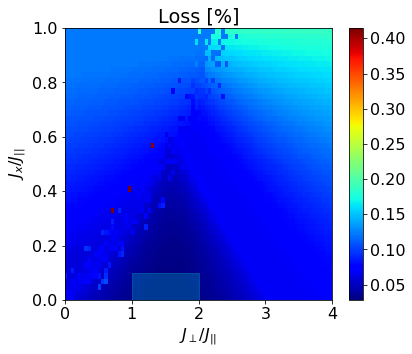

In [23]:
for training in range(3):
    t0 = time.time()
    tf.keras.backend.clear_session()
    train_xs = train_xss[training]
    train_ys = train_yss[training]
    x_train = []
    for xs,ys in zip(train_xs,train_ys):
        x_train.append(x_test[train_mask(*xs,*ys)])
    print([_.shape for _ in x_train])
    x_train = np.concatenate(x_train)
    print(x_train.shape)

    cnns[training] = training_run(x_train,choose_cnn = cnnx, name = name, provide_cnn = False,
                 load_prev=False, num_epochs = num_epochs[training],  verbose_val=1, batch_size = 128, shuffle=True, early=False,
                 loss="mse", activation0 = 'relu', activation = 'linear', optimizer = "adam")
    print("dt = ", time.time()-t0)
    images_out = cnns[training].predict(x_test)
    res = eval_loss(x_test,images_out,norm=norm2)/eval_loss(x_test,0*x_test,norm=norm2)
    Z = np.zeros((len(uy),len(ux)))
    for j in range(len(ux)):
        for i in range(len(uy)):
            x,y = X[i,j],Y[i,j]
            pickx = np.where(xx == x)
            picky = np.where(yy == y)
            pick = np.intersect1d(pickx,picky)
            Z[i,j] = res[pick[0]]
    outs[training] = Z

    fig, ax = plt.subplots()
    # plot result
    im = ax.pcolormesh(X,Y,outs[training],cmap="jet")
    fig.colorbar(im,ax=ax)
    for xs,ys in zip(train_xs,train_ys):
        plt.fill_between(*[xs],*ys,color="c",alpha=0.3)
    ax.set_xlabel("$J_\perp/J_{{||}}$")
    ax.set_ylabel("$J_x/J_{{||}}$")
    ax.set_title("Loss [%]")
    plt.savefig("plots/" + name + f"_training_{training}.png")
    plt.show()

In [24]:
# by hand, these were outliers in all trainings
outliers = np.array([ 663, 1161, 2900])

In [25]:
for training in range(3):
    images_out = cnns[training].predict(x_test)
    res = eval_loss(x_test,images_out,norm=norm2)/eval_loss(x_test,0*x_test,norm=norm2)
    res[(outliers)] = np.array([None,None,None])
    Z = np.zeros((len(uy),len(ux)))
    for j in range(len(ux)):
        for i in range(len(uy)):
            x,y = X[i,j],Y[i,j]
            pickx = np.where(xx == x)
            picky = np.where(yy == y)
            pick = np.intersect1d(pickx,picky)
            Z[i,j] = res[pick[0]]
    outs[training] = Z

In [26]:
# load results from previous notebook
temps = [np.load("data_results/1-0_data.npz",allow_pickle=True)]

In [27]:
vmin, vmax = np.nanmin(outs[:3]), np.nanmax(outs[:3])

(0, 1) (0.8, 1)
(3, 4) (0.8, 1)
(1, 2) (0, 0.1)


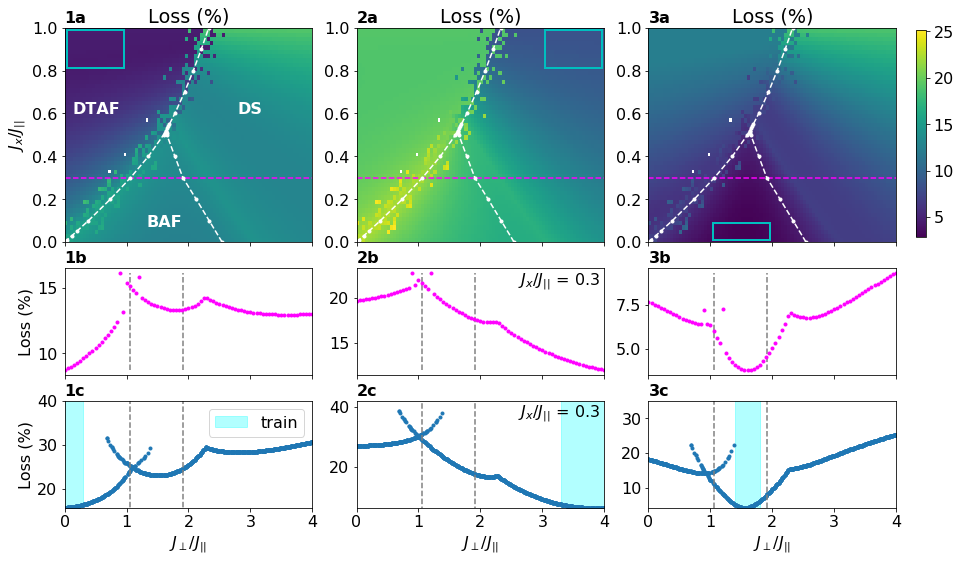

In [31]:
fig, axs = plt.subplots(3, 3, gridspec_kw={'height_ratios': [3, 1.5,1.5]},figsize=(14,8),sharex="col") #,sharey="row")

fillalpha, fillcolor = 0.5, "c"
cmap = "viridis" #"viridis" #"seismic" # "jet","seismic" # good diverging cmap: "seismic" https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
vmin, vmax = 100*np.nanmin(outs), 100*np.nanmax(outs)
pickys = [15,15,15]
for i in range(3):
    ax = axs[0,i]
    im = ax.pcolormesh(X,Y,100*outs[i],cmap=cmap,vmin=vmin, vmax=vmax,linewidth=0,rasterized=True) #, vmin=vmin, vmax=vmax
    im.set_edgecolor('face')
    #cbar = fig.colorbar(im,ax=ax)
    ax.set_title("Loss (%)")
    for phases,freqs in zip(train_xss[i],train_yss[i]):
        print(phases,freqs)
        # I am sure this can be done more elegantly, but aint nobody got time for that:
        rectcolor="c"
        ax.plot([phases[0]+0.04,phases[1]-0.04],[freqs[0]+0.01]*2,"-",linewidth=2,color=rectcolor)
        ax.plot([phases[0]+0.04,phases[1]-0.04],[freqs[1]-0.01]*2,"-",linewidth=2,color=rectcolor)
        ax.plot([phases[0]+0.04]*2,[freqs[0]+0.01,freqs[1]-0.01],"-",linewidth=2,color=rectcolor)
        ax.plot([phases[1]-0.04]*2,[freqs[0]+0.01,freqs[1]-0.01],"-",linewidth=2,color=rectcolor)
        #ax.plot(phases,[freqs[0]]*2,"-",linewidth=1,color=rectcolor)
        #ax.plot(phases,[freqs[1]]*2,"-",linewidth=1,color=rectcolor)
        #ax.plot([phases[0]]*2,freqs,"-",linewidth=1,color=rectcolor)
        #ax.plot([phases[1]]*2,freqs,"-",linewidth=1,color=rectcolor)
    pick_phase= pickys[i]
    ax.plot([0,4],[Y[pick_phase,0]]*2,"--",color="magenta")
    ax = axs[1,i]
    single_cut = 100*outs[i][pick_phase]
    
    ax.plot([theory_1st[6,1]]*2,[single_cut.min(),single_cut.max()],"--",color="grey")
    ax.plot([theory_2nd[3,1]]*2,[single_cut.min(),single_cut.max()],"--",color="grey")
    label = None
    if i == 0:
        label = "data"
        label1 = "training region"
    ax.plot(X[pick_phase],single_cut,".",label=label,color="magenta")

# Third row single cut data
col = 0
outsX = temps[col]["outs"]
xxX = temps[col]["xx"]
train1s = temps[col]["train1s"]
for i,train1 in enumerate(train1s):
    ax = axs[2,i]
    out = outsX[i]/np.max(outsX[i])
    ax.plot(xxX,100*out,".") #,label="$\lambda^k_\ell$")
axs[2,0].set_ylim(100*np.min(outsX[0]/np.max(outsX[0])),40) # leave outliers be
axs[2,1].set_ylim(100*np.min(outsX[1]/np.max(outsX[1])),42)
axs[2,2].set_ylim(100*np.min(outsX[2]/np.max(outsX[2])),35)
for i in range(3):
    axs[2,i].fill_between(*[train1s[i]],-0.5,200,alpha=0.3,color="cyan",label="train")
    axs[2,i].plot([theory_1st[6,1]]*2,[-0.5,200],"--",color="grey")
    axs[2,i].plot([theory_2nd[3,1]]*2,[-0.5,200],"--",color="grey")
axs[2,0].legend()


handles, labels = axs[1,0].get_legend_handles_labels()
#axs[1,0].legend(handles, labels,bbox_to_anchor=(0.3, 1.02, 2.5, .102), loc='lower left',
#           ncol=5, mode="expand", borderaxespad=0.)
theorycolor="white"
for i in range(3):
    axs[0,i].plot(theory_1st[:,1],theory_1st[:,0],".--",color=theorycolor,label="Extrap. Transition")
    axs[0,i].plot(theory_2nd[:,1],theory_2nd[:,0],".--",color=theorycolor)

plt.tight_layout()
for i in range(3):
    axs[2,i].set_xlabel("$J_\perp/J_{{||}}$")
    #axs[1,i].text(0.35, 1.1,"$J_x/J_{{||}}$ = {:.1f}".format(Y[pick_phase,0]), transform = axs[1,i].transAxes,fontsize=16)
axs[1,1].text(0.65,0.85,"$J_x/J_{{||}}$ = {:.1f}".format(Y[pick_phase,0]),fontsize=16,transform = axs[1,1].transAxes)
axs[2,1].text(0.65,0.85,"$J_x/J_{{||}}$ = 0.3",fontsize=16,transform = axs[2,1].transAxes)
axs[1,0].set_ylabel("Loss (%)")
axs[2,0].set_ylabel("Loss (%)")
axs[0,0].set_ylabel("$J_x/J_{{||}}$")


axs[0,0].text(0.03, 0.6,"DTAF",weight="bold", color="white", transform = axs[0,0].transAxes,fontsize=16)
axs[0,0].text(0.33, 0.07,"BAF",weight="bold", color="white", transform = axs[0,0].transAxes,fontsize=16)
axs[0,0].text(0.7, 0.6,"DS",weight="bold", color="white", transform = axs[0,0].transAxes,fontsize=16)

for i in range(3):
    axs[0,i].text(0, 1.025,f"{i+1}a",weight="bold", transform = axs[0,i].transAxes,fontsize=16)
    axs[1,i].text(0, 1.05,f"{i+1}b",weight="bold", transform = axs[1,i].transAxes,fontsize=16)
    axs[2,i].text(0, 1.05,f"{i+1}c",weight="bold", transform = axs[2,i].transAxes,fontsize=16)
# colorbar

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.57, 0.01, 0.36]) #left, bottom, width, height
fig.colorbar(im, cax=cbar_ax)
#cbar_ax.set_title("  Loss (%)")
plt.gcf().subplots_adjust(bottom=0.1,left=0.075)
plt.savefig("plots/random_master_" + cmap + "_all_outliers-removed.pdf")
plt.savefig("plots/random_master_" + cmap + "_all_outliers-removed.png")